In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Model
from tensorflow.keras.utils import get_file, plot_model


In [2]:
sns.set(style='white')
plt.style.use('seaborn-white')

In [5]:
datasets_path = get_file('auto-mpg.data','http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data')
datasets_path

'C:\\Users\\bitcamp\\.keras\\datasets\\auto-mpg.data'

In [6]:
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model Year', 'Origin']

In [9]:
raw_dataset = pd.read_csv(datasets_path, names=column_names, na_values='?', comment='\t', sep=' ', skipinitialspace=True)

dataset = raw_dataset.copy()
dataset

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1
...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1


In [10]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [11]:
dataset= dataset.dropna()

In [12]:
dataset['Origin'].unique()

array([1, 3, 2], dtype=int64)

In [13]:
origin = dataset.pop('Origin')

In [14]:
dataset['USA'] = (origin==1)*1.0
dataset['Europe'] = (origin==2)*1.0
dataset['Japan'] = (origin==3)*1.0
dataset


C:\Users\bitcamp\AppData\Local\Temp/ipykernel_11856/4259956368.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['USA'] = (origin==1)*1.0
C:\Users\bitcamp\AppData\Local\Temp/ipykernel_11856/4259956368.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Europe'] = (origin==2)*1.0
C:\Users\bitcamp\AppData\Local\Temp/ipykernel_11856/4259956368.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
0,18.0,8,307.0,130.0,3504.0,12.0,70,1.0,0.0,0.0
1,15.0,8,350.0,165.0,3693.0,11.5,70,1.0,0.0,0.0
2,18.0,8,318.0,150.0,3436.0,11.0,70,1.0,0.0,0.0
3,16.0,8,304.0,150.0,3433.0,12.0,70,1.0,0.0,0.0
4,17.0,8,302.0,140.0,3449.0,10.5,70,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0


In [15]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

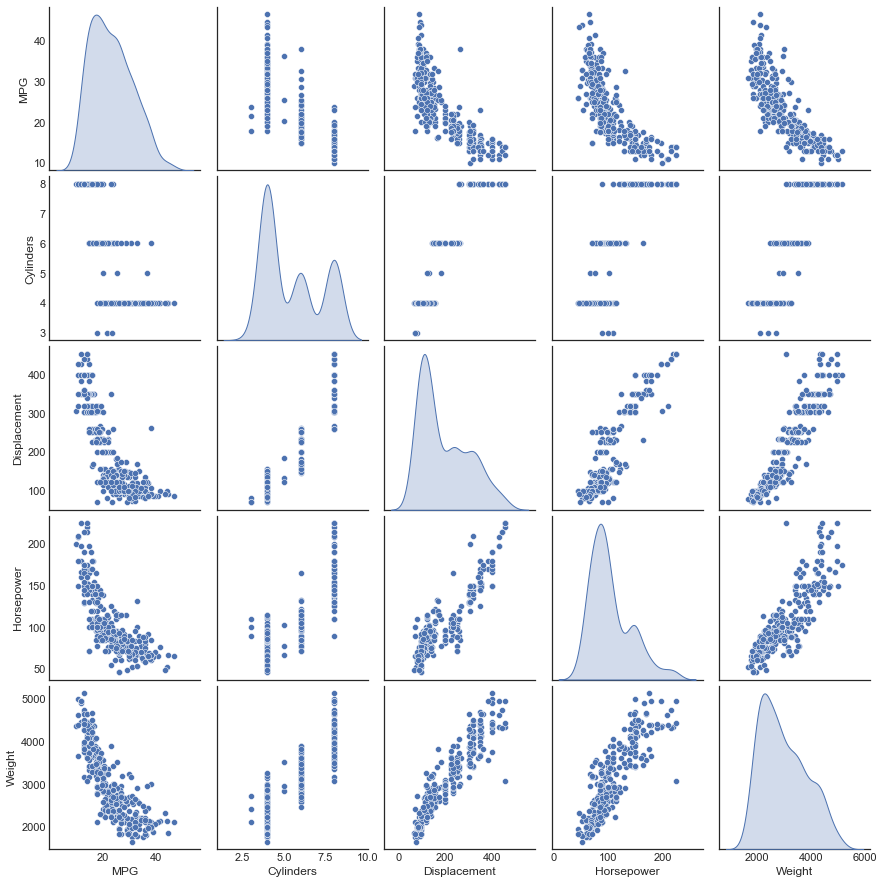

In [17]:
sns.pairplot(train_dataset[['MPG','Cylinders','Displacement','Horsepower','Weight']], diag_kind='kde');

In [18]:
train_stats = train_dataset.describe()
train_stats.pop('MPG')
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


In [19]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

In [20]:
def normalization(x):
    return (x - train_stats['mean']) / train_stats['std']

normed_train_data = normalization(train_dataset)
normed_test_data = normalization(test_dataset)

In [21]:
def build_model():
    input = Input(shape=(len(train_dataset.keys())), name='input')
    hidden1 = Dense(64, activation='relu', name='dense1')(input)
    hidden2 = Dense(64, activation='relu', name='dense2')(hidden1)
    output = Dense(1, name='output')(hidden2)
    
    model = Model(inputs=[input], outputs=output)
    
    model.compile(loss='mse', optimizer=RMSprop(0.001), metrics=['mae', 'mse'])
    
    return model

In [22]:
model = build_model()

In [23]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 9)]               0         
                                                                 
 dense1 (Dense)              (None, 64)                640       
                                                                 
 dense2 (Dense)              (None, 64)                4160      
                                                                 
 output (Dense)              (None, 1)                 65        
                                                                 
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


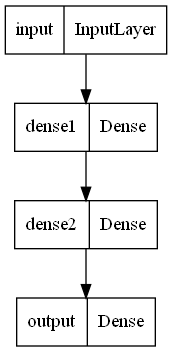

In [24]:
plot_model(model)

In [25]:
sample_batch = normed_train_data[:10]
sample_result = model.predict(sample_batch)
sample_batch

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
146,-0.869348,-1.009459,-0.784052,-1.025303,-0.379759,-0.516397,0.774676,-0.465148,-0.495225
282,-0.869348,-0.530218,-0.442811,-0.118796,0.624102,0.843910,0.774676,-0.465148,-0.495225
69,1.483887,1.482595,1.447140,1.736877,-0.738281,-1.060519,0.774676,-0.465148,-0.495225
378,-0.869348,-0.865687,-1.099044,-1.025303,-0.308055,1.660094,0.774676,-0.465148,-0.495225
331,-0.869348,-0.942365,-0.994047,-1.001603,0.875068,1.115971,-1.286751,-0.465148,2.012852
257,0.307270,0.351586,-0.390312,0.260397,0.588250,0.571849,0.774676,-0.465148,-0.495225
310,-0.869348,-1.019044,-1.177792,-1.211344,1.161885,1.115971,-1.286751,-0.465148,2.012852
328,-0.869348,-0.472709,-0.994047,0.307796,2.237451,1.115971,-1.286751,2.143005,-0.495225
125,0.307270,0.025702,-0.259066,0.132419,0.337285,-0.516397,0.774676,-0.465148,-0.495225
108,-0.869348,-0.942365,-0.442811,-0.842816,1.233589,-0.788458,-1.286751,-0.465148,2.012852


In [26]:
epochs = 1000

history = model.fit(normed_train_data, train_labels, epochs=epochs, validation_split=0.2)

Epoch 1/1000
8/8 [==============================] - 1s 34ms/step - loss: 552.4480 - mae: 22.2130 - mse: 552.4480 - val_loss: 535.9641 - val_mae: 21.8262 - val_mse: 535.9641
Epoch 2/1000
8/8 [==============================] - 0s 15ms/step - loss: 491.4154 - mae: 20.8729 - mse: 491.4154 - val_loss: 470.0982 - val_mae: 20.3566 - val_mse: 470.0982
Epoch 3/1000
8/8 [==============================] - 0s 12ms/step - loss: 431.2619 - mae: 19.4724 - mse: 431.2619 - val_loss: 402.5506 - val_mae: 18.7294 - val_mse: 402.5506
Epoch 4/1000
8/8 [==============================] - 0s 12ms/step - loss: 366.3183 - mae: 17.8517 - mse: 366.3183 - val_loss: 329.4099 - val_mae: 16.8122 - val_mse: 329.4099
Epoch 5/1000
8/8 [==============================] - 0s 12ms/step - loss: 298.8940 - mae: 16.0017 - mse: 298.8940 - val_loss: 256.6960 - val_mae: 14.6564 - val_mse: 256.6960
Epoch 6/1000
8/8 [==============================] - 0s 12ms/step - loss: 232.2465 - mae: 13.9141 - mse: 232.2465 - val_loss: 188.3229 -

In [27]:
history.history.keys()

dict_keys(['loss', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse'])

In [28]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
0,552.447998,22.212976,552.447998,535.964050,21.826172,535.964050,0
1,491.415375,20.872875,491.415375,470.098206,20.356554,470.098206,1
2,431.261871,19.472435,431.261871,402.550629,18.729357,402.550629,2
3,366.318329,17.851702,366.318329,329.409851,16.812218,329.409851,3
4,298.894043,16.001734,298.894043,256.695984,14.656368,256.695984,4
...,...,...,...,...,...,...,...
995,2.289752,0.982938,2.289752,10.737650,2.512368,10.737650,995
996,2.501567,1.039251,2.501567,10.601718,2.521377,10.601718,996
997,2.562159,1.008408,2.562159,10.211796,2.427867,10.211796,997
998,2.299943,0.972004,2.299943,10.220788,2.446681,10.220788,998


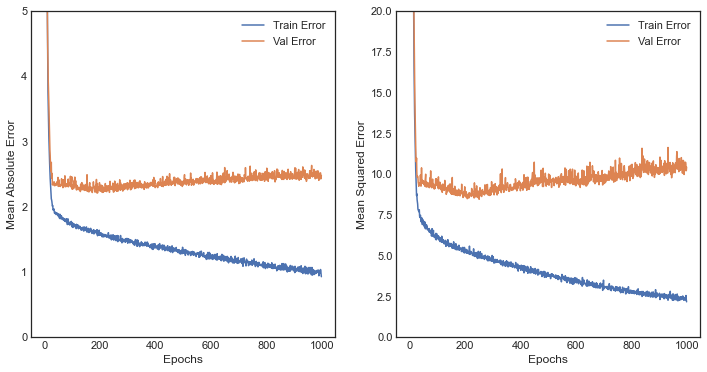

In [29]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch']=history.epoch
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2,1)
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Error')
    plt.plot(hist['epoch'], hist['mae'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'], label='Val Error')
    plt.ylim([0,5])
    plt.legend()
    
    plt.subplot(1, 2,2)
    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error')
    plt.plot(hist['epoch'], hist['mse'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'], label='Val Error')
    plt.ylim([0,20])
    plt.legend()
    
    plt.show()
    
plot_history(history)

In [30]:
from tensorflow.keras.callbacks import EarlyStopping

In [31]:
model = build_model()

early_stop = EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=epochs,validation_split=0.2, callbacks=[early_stop])

Epoch 1/1000
8/8 [==============================] - 1s 27ms/step - loss: 553.2210 - mae: 22.2809 - mse: 553.2210 - val_loss: 534.4673 - val_mae: 21.9262 - val_mse: 534.4673
Epoch 2/1000
8/8 [==============================] - 0s 13ms/step - loss: 488.6593 - mae: 20.9253 - mse: 488.6593 - val_loss: 467.5781 - val_mae: 20.4865 - val_mse: 467.5781
Epoch 3/1000
8/8 [==============================] - 0s 12ms/step - loss: 426.3177 - mae: 19.5267 - mse: 426.3177 - val_loss: 395.8748 - val_mae: 18.8021 - val_mse: 395.8748
Epoch 4/1000
8/8 [==============================] - 0s 13ms/step - loss: 358.3092 - mae: 17.8705 - mse: 358.3092 - val_loss: 319.2953 - val_mae: 16.7972 - val_mse: 319.2953
Epoch 5/1000
8/8 [==============================] - 0s 12ms/step - loss: 287.9975 - mae: 15.9369 - mse: 287.9975 - val_loss: 243.8452 - val_mae: 14.5150 - val_mse: 243.8452
Epoch 6/1000
8/8 [==============================] - 0s 12ms/step - loss: 220.8716 - mae: 13.7904 - mse: 220.8716 - val_loss: 177.9193 -

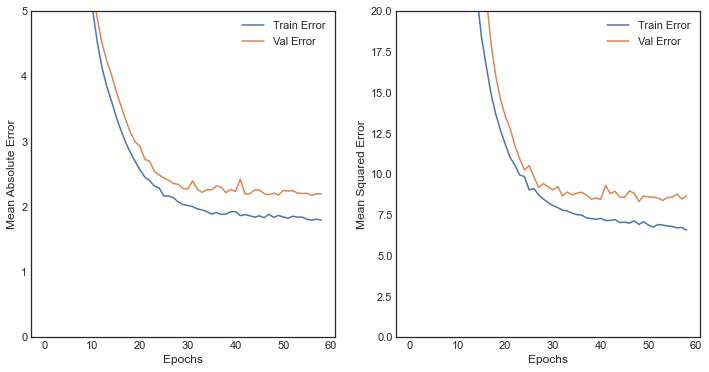

In [32]:
plot_history(history)

In [33]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print(mae)

3/3 - 0s - loss: 5.9062 - mae: 1.9278 - mse: 5.9062 - 49ms/epoch - 16ms/step
1.9277613162994385


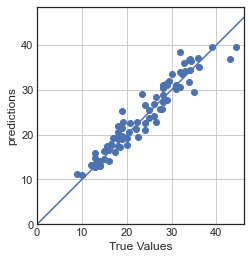

In [35]:
test_pred = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_pred)
plt.xlabel('True Values')
plt.ylabel('predictions')
plt.axis('equal')
plt.axis('square')
plt.grid()
plt.xlim([0, plt.xlim()[1]])
plt.ylim([0, plt.ylim()[1]])
plt.plot([-100, 100], [-100, 100]);

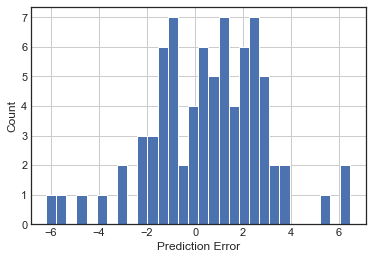

In [36]:
error = test_pred - test_labels
plt.hist(error, bins=30)
plt.xlabel('Prediction Error')
plt.grid()
plt.ylabel('Count');